In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import detrend
from scipy.fft import fft
from statsmodels.tsa.seasonal import seasonal_decompose
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
import json
from datetime import datetime, timedelta, time
import pytz


In [3]:
KEY = "XpqF6xBLLrj6WALk4SS1UlkgphXmHQec"

class CustomRetry(Retry):
    def is_retry(self, method, status_code, has_retry_after=False):
        """ Return True if we should retry the request, otherwise False. """
        if status_code != 200:
            return True
        return super().is_retry(method, status_code, has_retry_after)
    
def convert_timestamp_est(timestamp):
    # Create a naive datetime object from the UNIX timestamp
    dt_naive = datetime.utcfromtimestamp(timestamp)
    # Convert the naive datetime object to a timezone-aware one (UTC)
    dt_utc = pytz.utc.localize(dt_naive)
    # Convert the UTC datetime to EST
    dt_est = dt_utc.astimezone(pytz.timezone('US/Eastern'))
    
    return dt_est
    

def setup_session_retries(
    retries: int = 3,
    backoff_factor: float = 0.05,
    status_forcelist: tuple = (500, 502, 504),
):
    """
    Sets up a requests Session with retries.
    
    Parameters:
    - retries: Number of retries before giving up. Default is 3.
    - backoff_factor: A factor to use for exponential backoff. Default is 0.3.
    - status_forcelist: A tuple of HTTP status codes that should trigger a retry. Default is (500, 502, 504).

    Returns:
    - A requests Session object with retry configuration.
    """
    retry_strategy = CustomRetry(
        total=retries,
        backoff_factor=backoff_factor,
        status_forcelist=status_forcelist,
        allowed_methods=frozenset(["GET", "POST", "PUT", "DELETE", "HEAD", "OPTIONS"]),
        raise_on_status=False
    )
    adapter = HTTPAdapter(max_retries=retry_strategy)
    session = requests.Session()
    session.mount("http://", adapter)
    session.mount("https://", adapter)
    
    return session

def execute_polygon_call(url):
    session = setup_session_retries()
    response = session.request("GET", url, headers={}, data={})
    return response 

def call_polygon(symbol, from_stamp, to_stamp, timespan, multiplier):
    hours = [9,10,11,12,13,14,15]
    url = f"https://api.polygon.io/v2/aggs/ticker/{symbol}/range/{multiplier}/{timespan}/{from_stamp}/{to_stamp}?adjusted=true&sort=asc&limit=50000&apiKey={KEY}"

    response = execute_polygon_call(url)

    response_data = json.loads(response.text)
    results = response_data['results']
    results_df = pd.DataFrame(results)
    results_df['t'] = results_df['t'].apply(lambda x: int(x/1000))
    results_df['date'] = results_df['t'].apply(lambda x: convert_timestamp_est(x))
    results_df['hour'] = results_df['date'].apply(lambda x: x.hour)
    results_df['day'] = results_df['date'].apply(lambda x: x.day)
    results_df['month'] = results_df['date'].apply(lambda x: x.month)
    results_df['year'] = results_df['date'].apply(lambda x: x.year)
    results_df['plot_date'] = results_df['date'].apply(lambda x: x.date())
    results_df = results_df[results_df['hour'].isin(hours)]
    results_df['symbol'] = symbol
    return results_df


In [14]:
def analyze_volume_trends(data, cycle_length=14):
    # Convert data to numpy array if it's not already
    volume = np.array(data)
    print(volume)
    
    # Detrend the data
    detrended = detrend(volume)
    
    # Perform FFT
    fft_result = fft(detrended)
    frequencies = np.fft.fftfreq(len(volume))
    
    # Filter out high-frequency components (adjust threshold as needed)
    threshold = 0.1
    fft_result[np.abs(frequencies) > threshold] = 0
    
    # Inverse FFT to get smoothed trend
    smoothed_trend = np.real(np.fft.ifft(fft_result))
    
    # Perform seasonal decomposition
    df = pd.DataFrame(volume, columns=['volume'])
    decomposition = seasonal_decompose(df, model='additive', period=cycle_length)
    
    # Plot results
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(12, 20))
    
    ax1.plot(volume, label='Original')
    ax1.set_title('Original Volume Data')
    ax1.legend()
    
    ax2.plot(smoothed_trend, label='Smoothed Trend (FFT)')
    ax2.set_title('Smoothed Trend using FFT')
    ax2.legend()
    
    ax3.plot(decomposition.trend, label='Trend (Seasonal Decompose)')
    ax3.set_title('Trend Component from Seasonal Decomposition')
    ax3.legend()
    
    ax4.plot(decomposition.seasonal, label='Seasonal')
    ax4.set_title('Seasonal Component')
    ax4.legend()
    
    ax5.plot(decomposition.resid, label='Residual')
    ax5.set_title('Residual Component (Small Fluctuations)')
    ax5.legend()
    
    plt.tight_layout()
    plt.show()
    
    return smoothed_trend, decomposition

                         date          v
10  2024-07-01 09:00:00-04:00   161383.0
11  2024-07-01 09:30:00-04:00  7820948.0
12  2024-07-01 10:00:00-04:00  6456208.0
13  2024-07-01 10:30:00-04:00  4269462.0
14  2024-07-01 11:00:00-04:00  3415506.0
..                        ...        ...
717 2024-08-01 13:30:00-04:00  3505931.0
718 2024-08-01 14:00:00-04:00  2884136.0
719 2024-08-01 14:30:00-04:00  2998257.0
720 2024-08-01 15:00:00-04:00  3032147.0
721 2024-08-01 15:30:00-04:00  7414885.0

[322 rows x 2 columns]
[  161383.  7820948.  6456208.  4269462.  3415506.  2788912.  4071411.
  5056594.  3379988.  2145394.  1995122.  2476866.  2794389.  5425994.
   166616.  7888553.  5690300.  5931065.  6024441.  2816773.  2335033.
  1685072.  1551568.  1655863.  2107021.  2913509.  1875662.  4872855.
   125943.  8168194.  5661196.  3406161.  3094392.  2498340.  2775996.
  5521902.   393114.    51101.    36411.    15997.    18854.    32619.
   164332.  9277681.  7234504.  4022160.  2861509.  274577

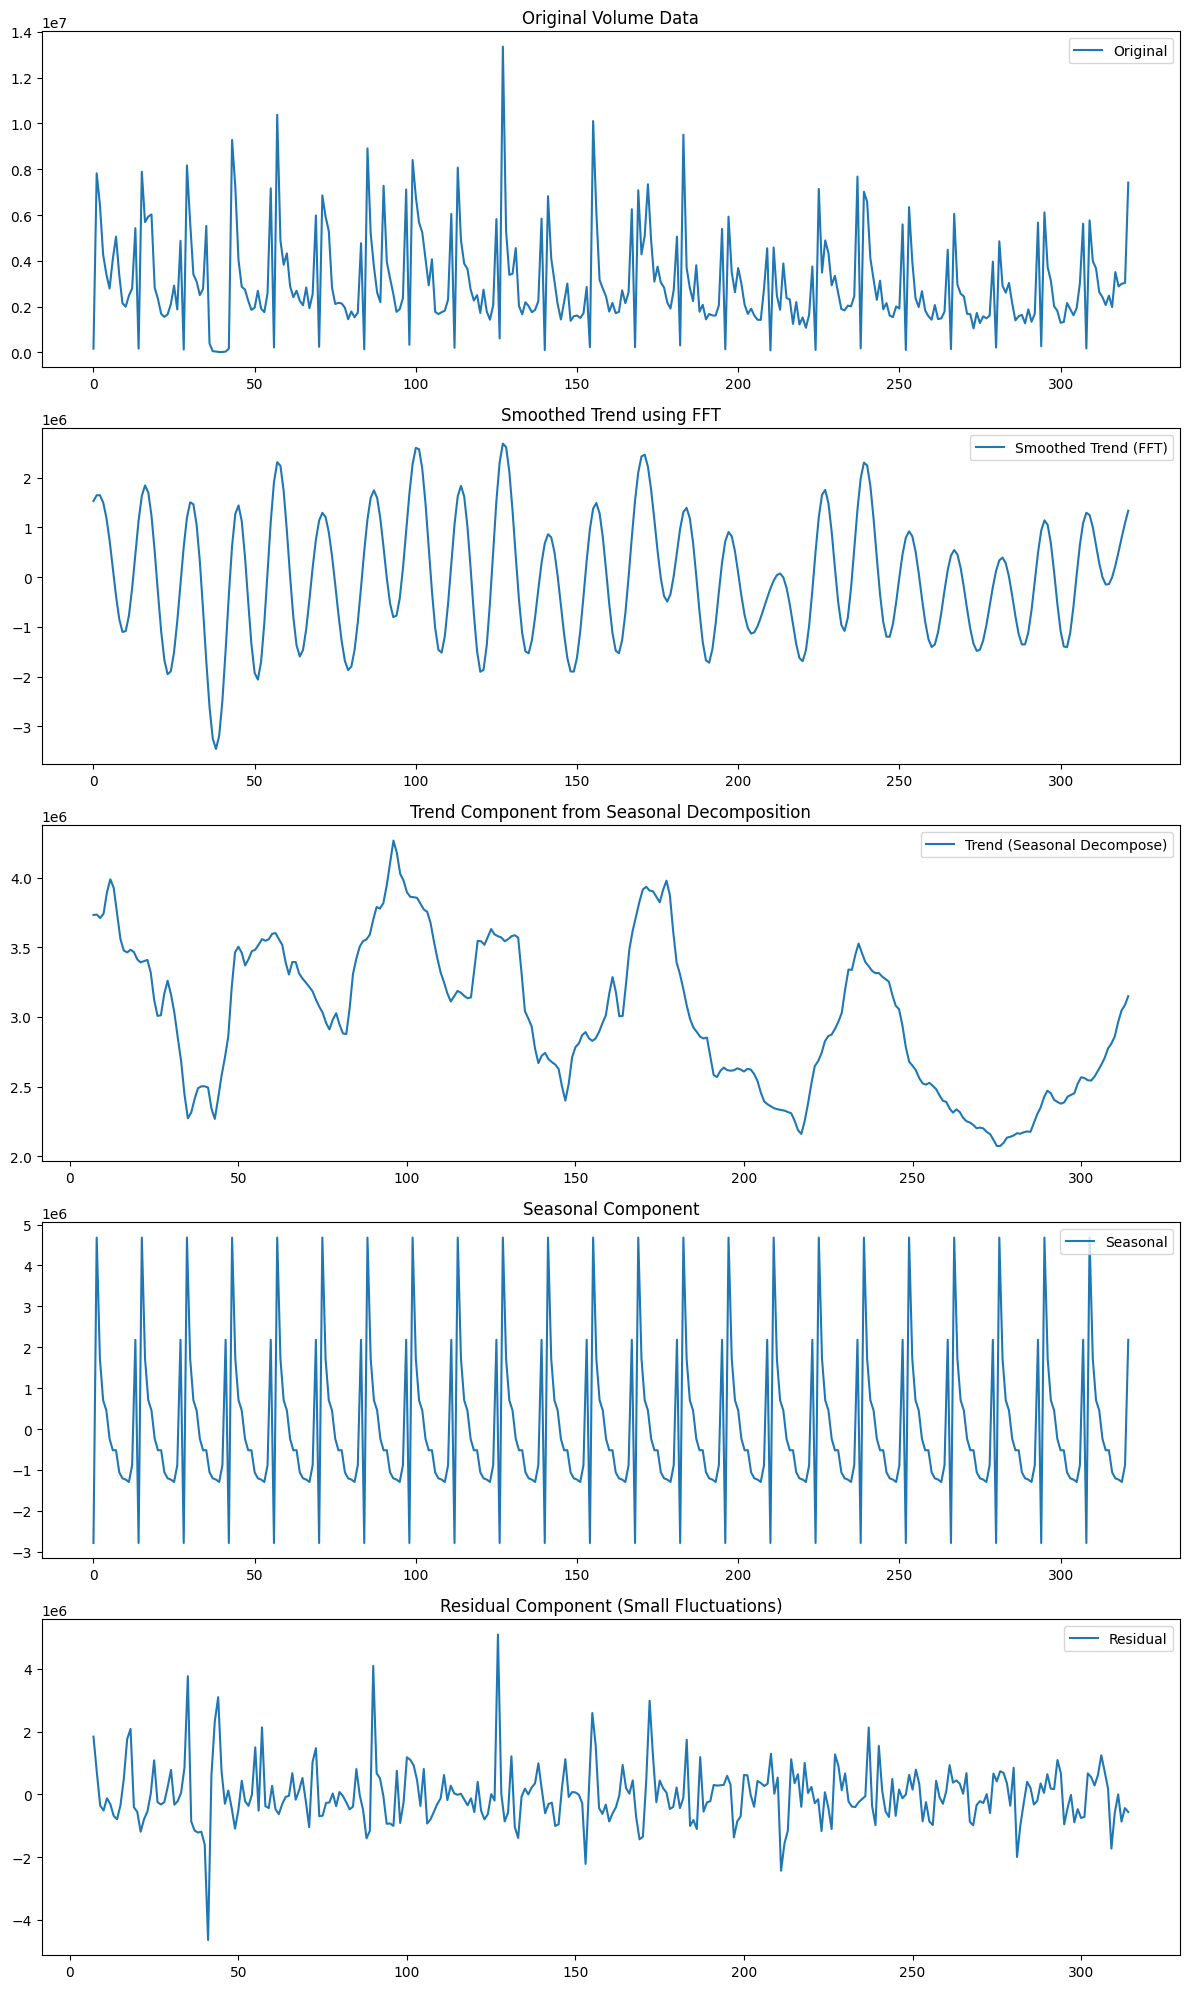

In [21]:
data = call_polygon("AAPL", "2024-07-01", "2024-08-01", "minute", 30)
print(data[['date','v']])
trend, decomp = analyze_volume_trends(data['v'], cycle_length=14)

### WAVELET PRICE

IndexError: index 5 is out of bounds for axis 0 with size 5

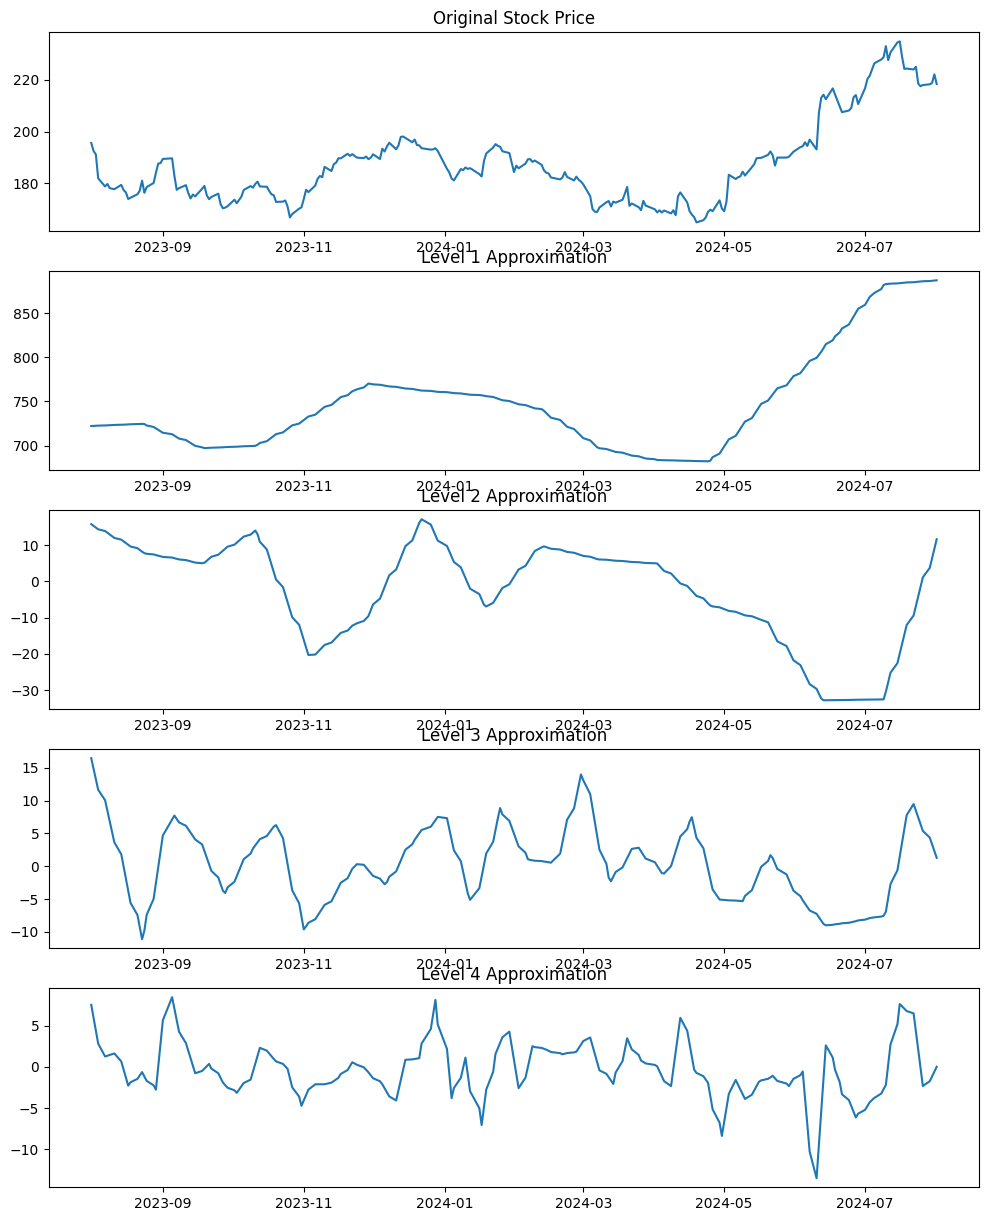

In [20]:
import pywt

data = call_polygon("AAPL", "2023-08-01", "2024-08-01", "day", 1)

# Simulated daily stock prices for 2 years
days = data['plot_date'].values
prices = data['c'].values
# Perform wavelet decomposition
coeffs = pywt.wavedec(prices, 'db1', level=4)

# Plot original signal and approximations
fig, axs = plt.subplots(5, 1, figsize=(12, 15))
axs[0].plot(days, prices)
axs[0].set_title('Original Stock Price')

for i, coeff in enumerate(coeffs):
    interp_coeff = np.interp(np.linspace(0, 1, len(days)), np.linspace(0, 1, len(coeff)), coeff)
    axs[i+1].plot(days, interp_coeff)
    axs[i+1].set_title(f'Level {i+1} Approximation')

plt.tight_layout()
plt.show()

In [22]:
def multi_scale_momentum(coeffs, weights=[0.5, 0.3, 0.2]):
    momentum = sum(np.sign(c[-1] - c[-2]) * w for c, w in zip(coeffs[1:4], weights))
    return momentum

momentum_signal = multi_scale_momentum(coeffs)
print(momentum_signal)

0.4


In [25]:
def volatility_breakout(detail, price, window=20, threshold=2):
    volatility = np.std(detail[-window:])
    vol_signal = abs(price[-1] - price[-2])/ volatility
    #     return price[-1] - price[-2]
    # return 0
    return vol_signal

breakout_signal = volatility_breakout(coeffs[1], prices)
print(breakout_signal)

0.23634664366129685


### WAVELET VOLUME

/Users/charlesmiller/.local/share/virtualenvs/dynamics_lab-m_GyQP7_/lib/python3.9/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 6 is too high: all coefficients will experience boundary effects.
  warnings.warn(


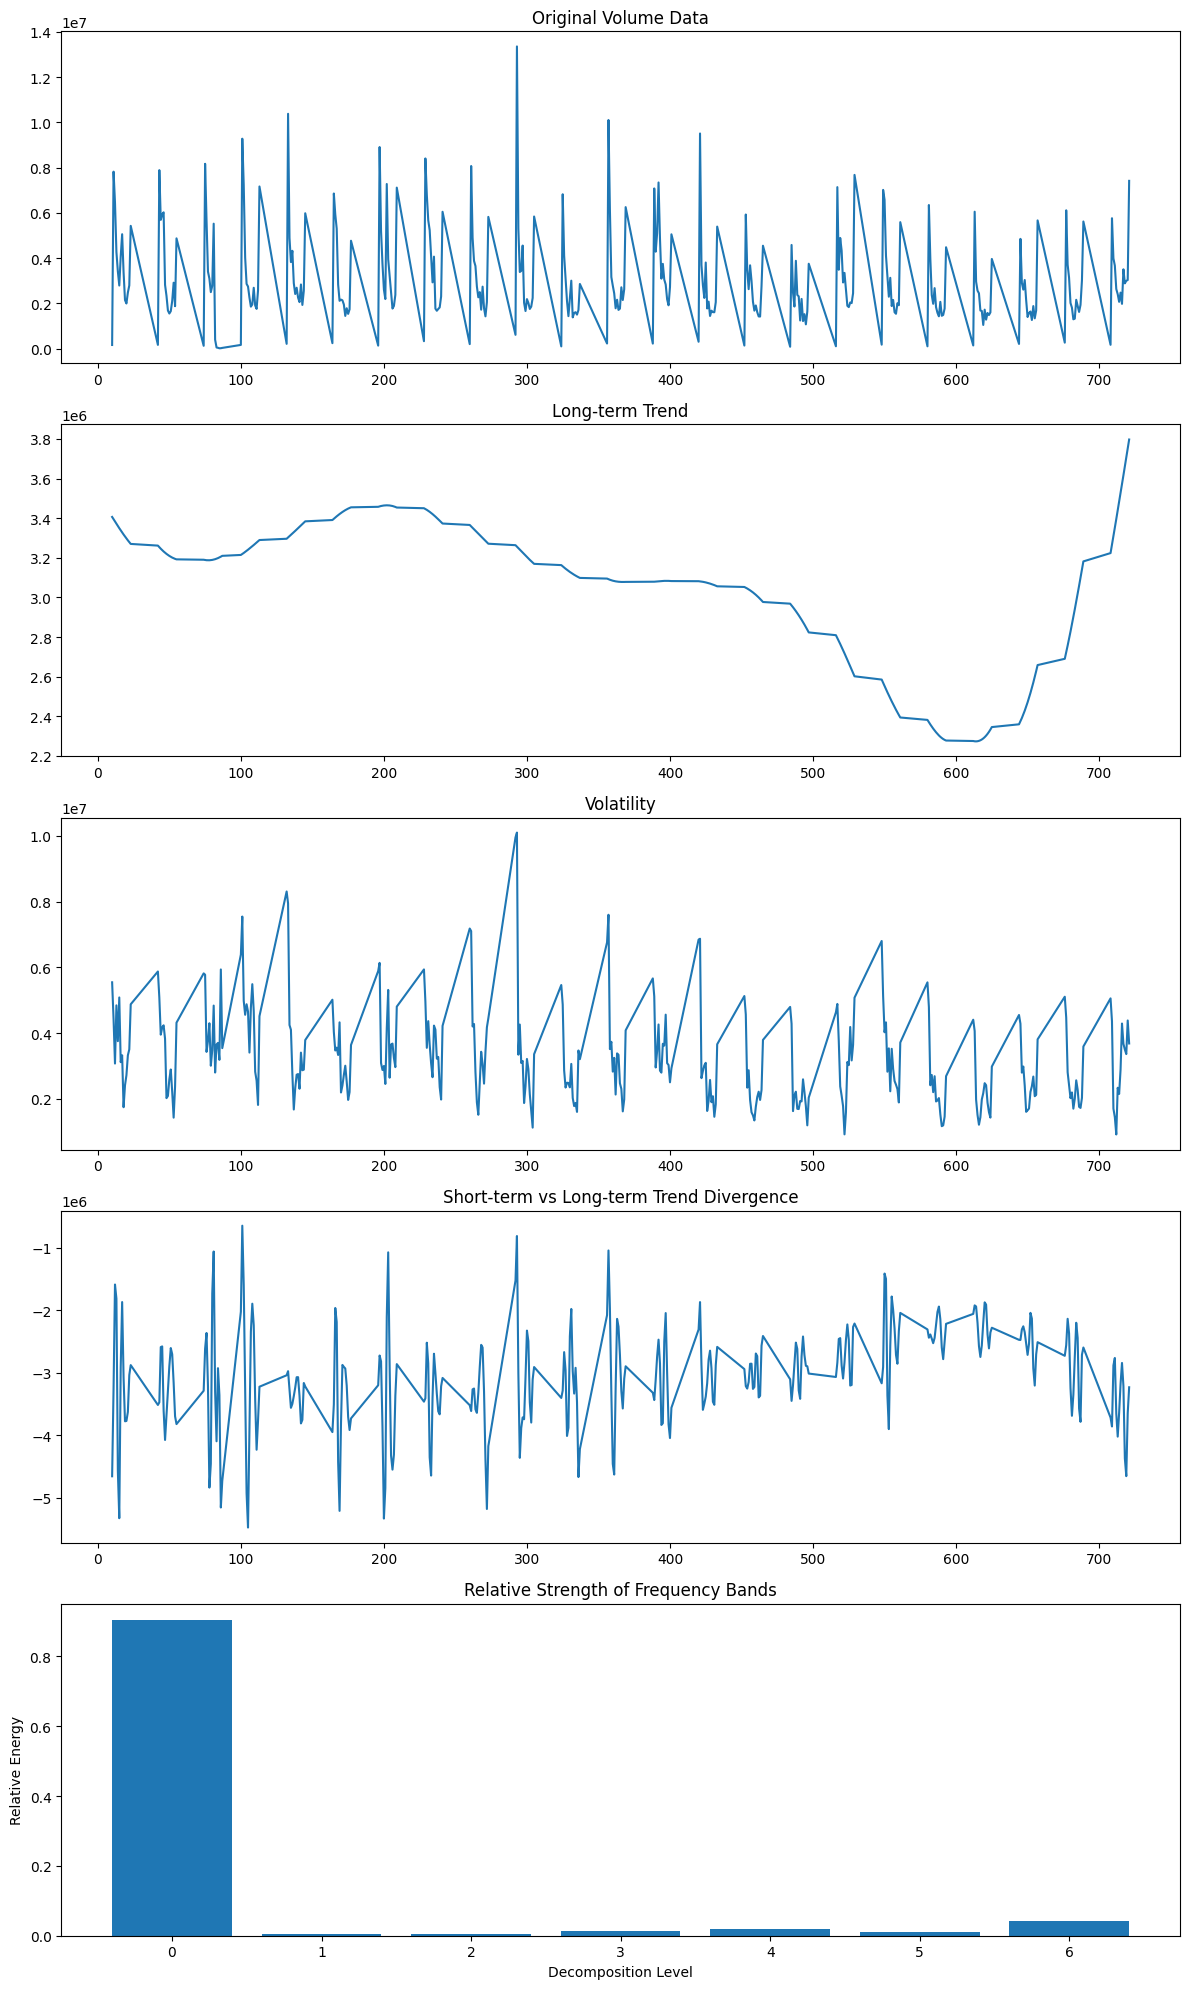

Average volatility: 3264118.03
Volatility of volatility: 1465257.72
Average divergence: 3050985.16
Number of volatility anomalies detected: 4
Top 5 anomalies:
293    13355651.0
133    10378309.0
292      610554.0
132      211952.0
Name: v, dtype: float64


In [32]:
import numpy as np
import pandas as pd
import pywt
import matplotlib.pyplot as plt
from scipy.stats import norm



# Load your data (replace this with your actual data loading code)
data = call_polygon("AAPL", "2024-07-01", "2024-08-01", "minute", 30)
volume_data = data['v']

# Perform wavelet decomposition
wavelet = 'db8'  # Daubechies 8 wavelet
level = 6  # Decomposition level
coeffs = pywt.wavedec(volume_data.values, wavelet, level=level)

# Reconstruct approximations and details
reconstructed = []
for i in range(level + 1):
    coeff_list = [np.zeros_like(c) for c in coeffs]
    coeff_list[i] = coeffs[i]
    reconstructed.append(pywt.waverec(coeff_list, wavelet))

# Analyze trend (approximation)
trend = reconstructed[0]

# Analyze volatility (details)
volatility = np.sum([np.abs(detail) for detail in reconstructed[1:]], axis=0)

# Measure short-term vs long-term trend divergence
short_term_trend = reconstructed[-2]  # Second to last level
long_term_trend = reconstructed[0]  # Approximation (lowest frequency)
divergence = short_term_trend - long_term_trend

# Calculate relative strength of each frequency band
total_energy = np.sum([np.sum(c**2) for c in coeffs])
relative_strength = [np.sum(c**2) / total_energy for c in coeffs]

# Plot results
fig, axs = plt.subplots(5, 1, figsize=(12, 20))

axs[0].plot(volume_data.index, volume_data.values)
axs[0].set_title('Original Volume Data')

axs[1].plot(volume_data.index, trend)
axs[1].set_title('Long-term Trend')

axs[2].plot(volume_data.index, volatility)
axs[2].set_title('Volatility')

axs[3].plot(volume_data.index, divergence)
axs[3].set_title('Short-term vs Long-term Trend Divergence')

axs[4].bar(range(level + 1), relative_strength)
axs[4].set_title('Relative Strength of Frequency Bands')
axs[4].set_xlabel('Decomposition Level')
axs[4].set_ylabel('Relative Energy')

plt.tight_layout()
plt.show()

# Print summary statistics
# print(f"Average daily volume: {volume_data.resample('D').mean().mean():.2f}")
print(f"Average volatility: {np.mean(volatility):.2f}")
print(f"Volatility of volatility: {np.std(volatility):.2f}")
print(f"Average divergence: {np.mean(np.abs(divergence)):.2f}")

# Detect anomalies in volatility
volatility_zscore = (volatility - np.mean(volatility)) / np.std(volatility)
anomalies = volume_data[np.abs(volatility_zscore) > 3]
print(f"Number of volatility anomalies detected: {len(anomalies)}")
if len(anomalies) > 0:
    print("Top 5 anomalies:")
    print(anomalies.sort_values(ascending=False).head())

/Users/charlesmiller/.local/share/virtualenvs/dynamics_lab-m_GyQP7_/lib/python3.9/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 6 is too high: all coefficients will experience boundary effects.
  warnings.warn(
/Users/charlesmiller/.local/share/virtualenvs/dynamics_lab-m_GyQP7_/lib/python3.9/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 8 is too high: all coefficients will experience boundary effects.
  warnings.warn(


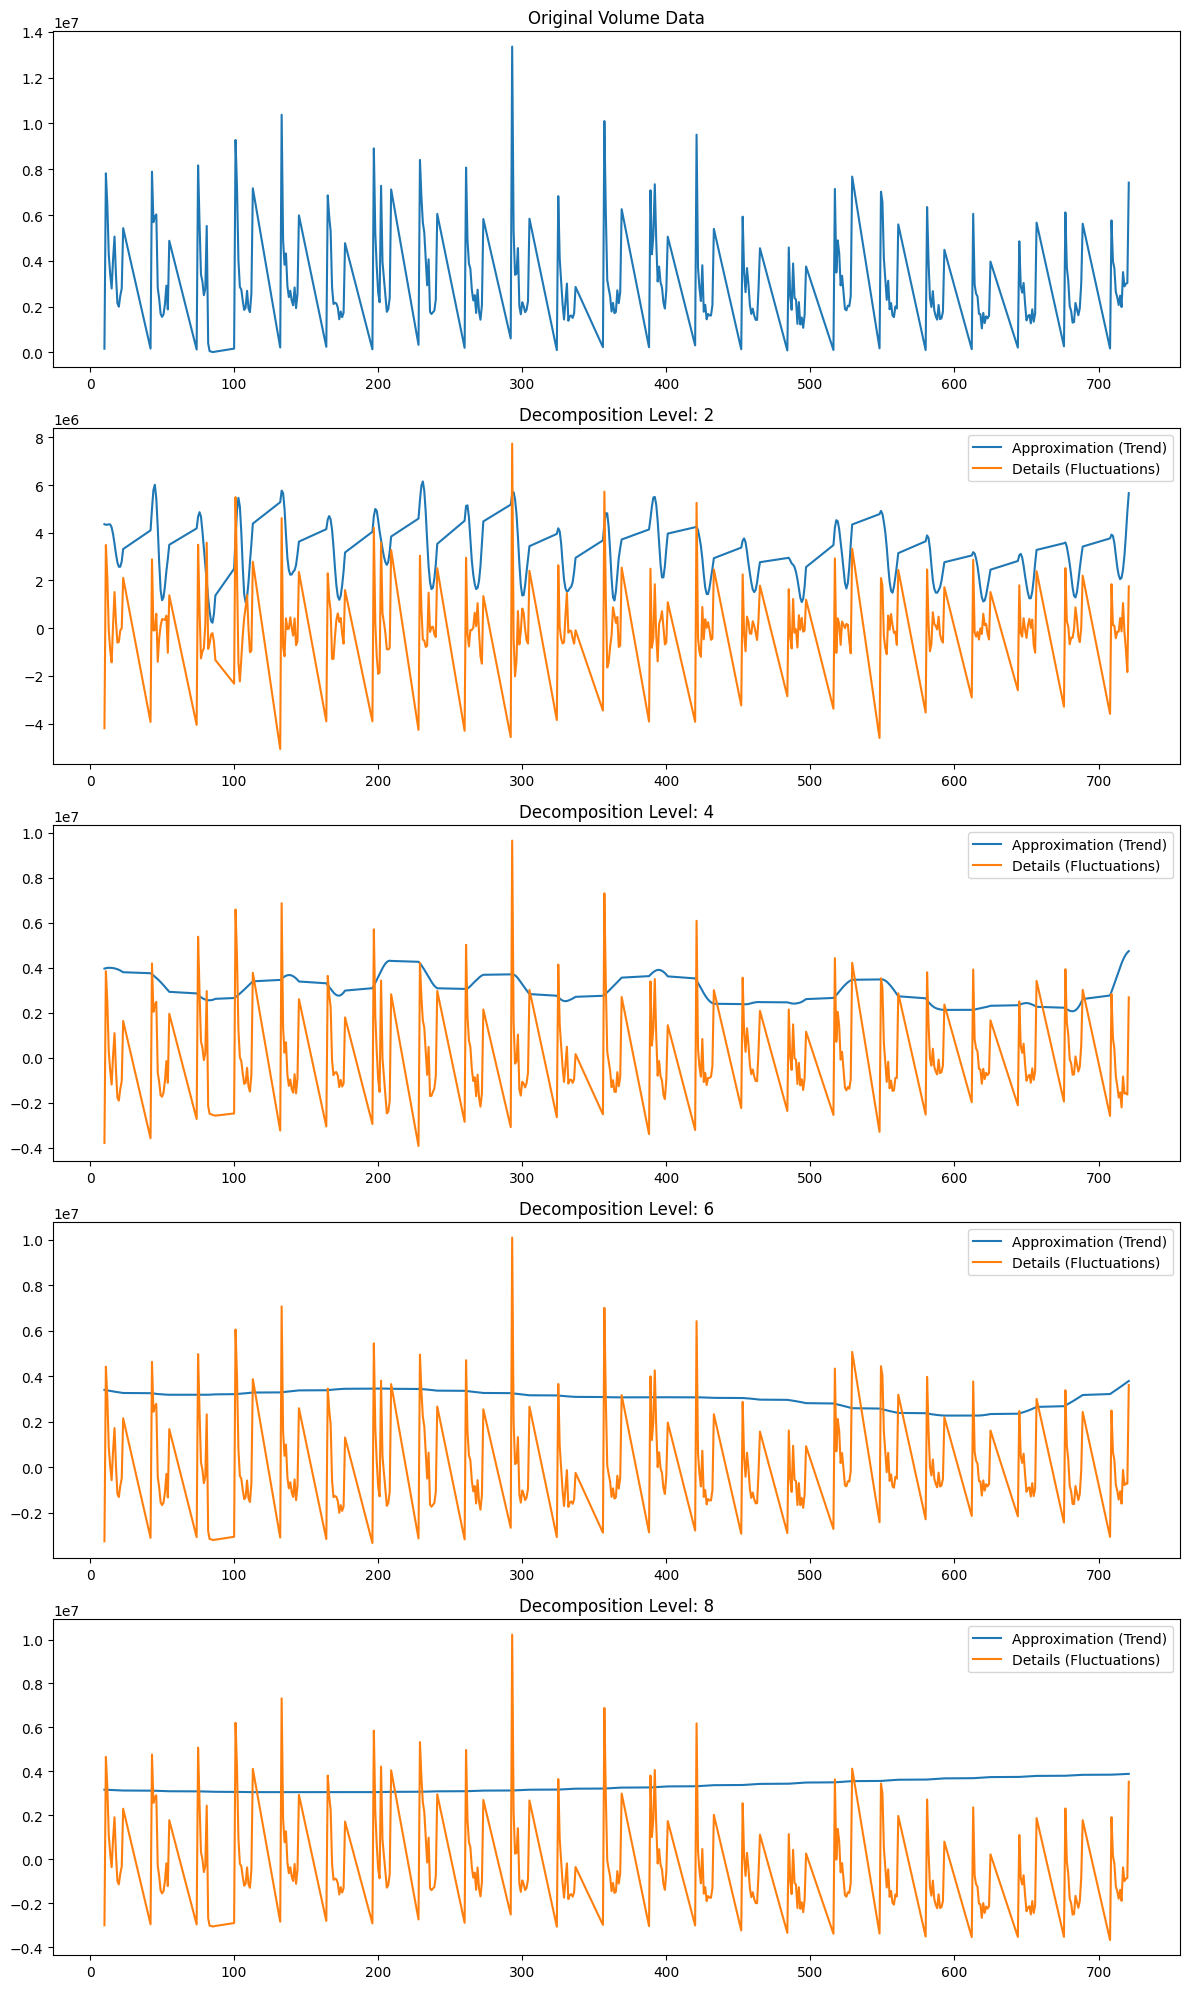


Decomposition Level: 2
Relative strength of each frequency band:
  Approximation (A2): 0.8130
  Detail D2: 0.0372
  Detail D1: 0.1499

Decomposition Level: 4
Relative strength of each frequency band:
  Approximation (A4): 0.8058
  Detail D4: 0.0311
  Detail D3: 0.0422
  Detail D2: 0.0240
  Detail D1: 0.0969

Decomposition Level: 6
Relative strength of each frequency band:
  Approximation (A6): 0.9056
  Detail D6: 0.0039
  Detail D5: 0.0041
  Detail D4: 0.0138
  Detail D3: 0.0188
  Detail D2: 0.0107
  Detail D1: 0.0431

Decomposition Level: 8
Relative strength of each frequency band:
  Approximation (A8): 0.9576
  Detail D8: 0.0125
  Detail D7: 0.0011
  Detail D6: 0.0012
  Detail D5: 0.0012
  Detail D4: 0.0042
  Detail D3: 0.0057
  Detail D2: 0.0033
  Detail D1: 0.0132

Optimal decomposition level for this data: 4


In [33]:
import numpy as np
import pandas as pd
import pywt
import matplotlib.pyplot as plt

data = call_polygon("AAPL", "2024-07-01", "2024-08-01", "minute", 30)
volume_data = data['v']

# Function to perform wavelet decomposition and reconstruction
def wavelet_analysis(data, wavelet='db8', max_level=6):
    coeffs = pywt.wavedec(data, wavelet, level=max_level)
    reconstructed = []
    for i in range(max_level + 1):
        coeff_list = [np.zeros_like(c) for c in coeffs]
        coeff_list[i] = coeffs[i]
        reconstructed.append(pywt.waverec(coeff_list, wavelet))
    return reconstructed

# Perform wavelet analysis for different levels
max_level = int(np.log2(len(volume_data)))
levels_to_analyze = [2, 4, 6, max_level]

fig, axs = plt.subplots(len(levels_to_analyze) + 1, 1, figsize=(12, 4 * (len(levels_to_analyze) + 1)))

# Plot original data
axs[0].plot(volume_data.index, volume_data.values)
axs[0].set_title('Original Volume Data')

for i, level in enumerate(levels_to_analyze, start=1):
    reconstructed = wavelet_analysis(volume_data.values, max_level=level)
    
    # Plot approximation (trend) and details (fluctuations)
    axs[i].plot(volume_data.index, reconstructed[0], label='Approximation (Trend)')
    axs[i].plot(volume_data.index, np.sum(reconstructed[1:], axis=0), label='Details (Fluctuations)')
    axs[i].set_title(f'Decomposition Level: {level}')
    axs[i].legend()

plt.tight_layout()
plt.show()

# Analyze frequency content at different levels
for level in levels_to_analyze:
    coeffs = pywt.wavedec(volume_data.values, 'db8', level=level)
    total_energy = np.sum([np.sum(c**2) for c in coeffs])
    relative_strength = [np.sum(c**2) / total_energy for c in coeffs]
    
    print(f"\nDecomposition Level: {level}")
    print("Relative strength of each frequency band:")
    for i, strength in enumerate(relative_strength):
        if i == 0:
            print(f"  Approximation (A{level}): {strength:.4f}")
        else:
            print(f"  Detail D{level-i+1}: {strength:.4f}")

# Calculate and print the optimal decomposition level
n = len(volume_data)
optimal_level = pywt.dwt_max_level(n, pywt.Wavelet('db8').dec_len)
print(f"\nOptimal decomposition level for this data: {optimal_level}")

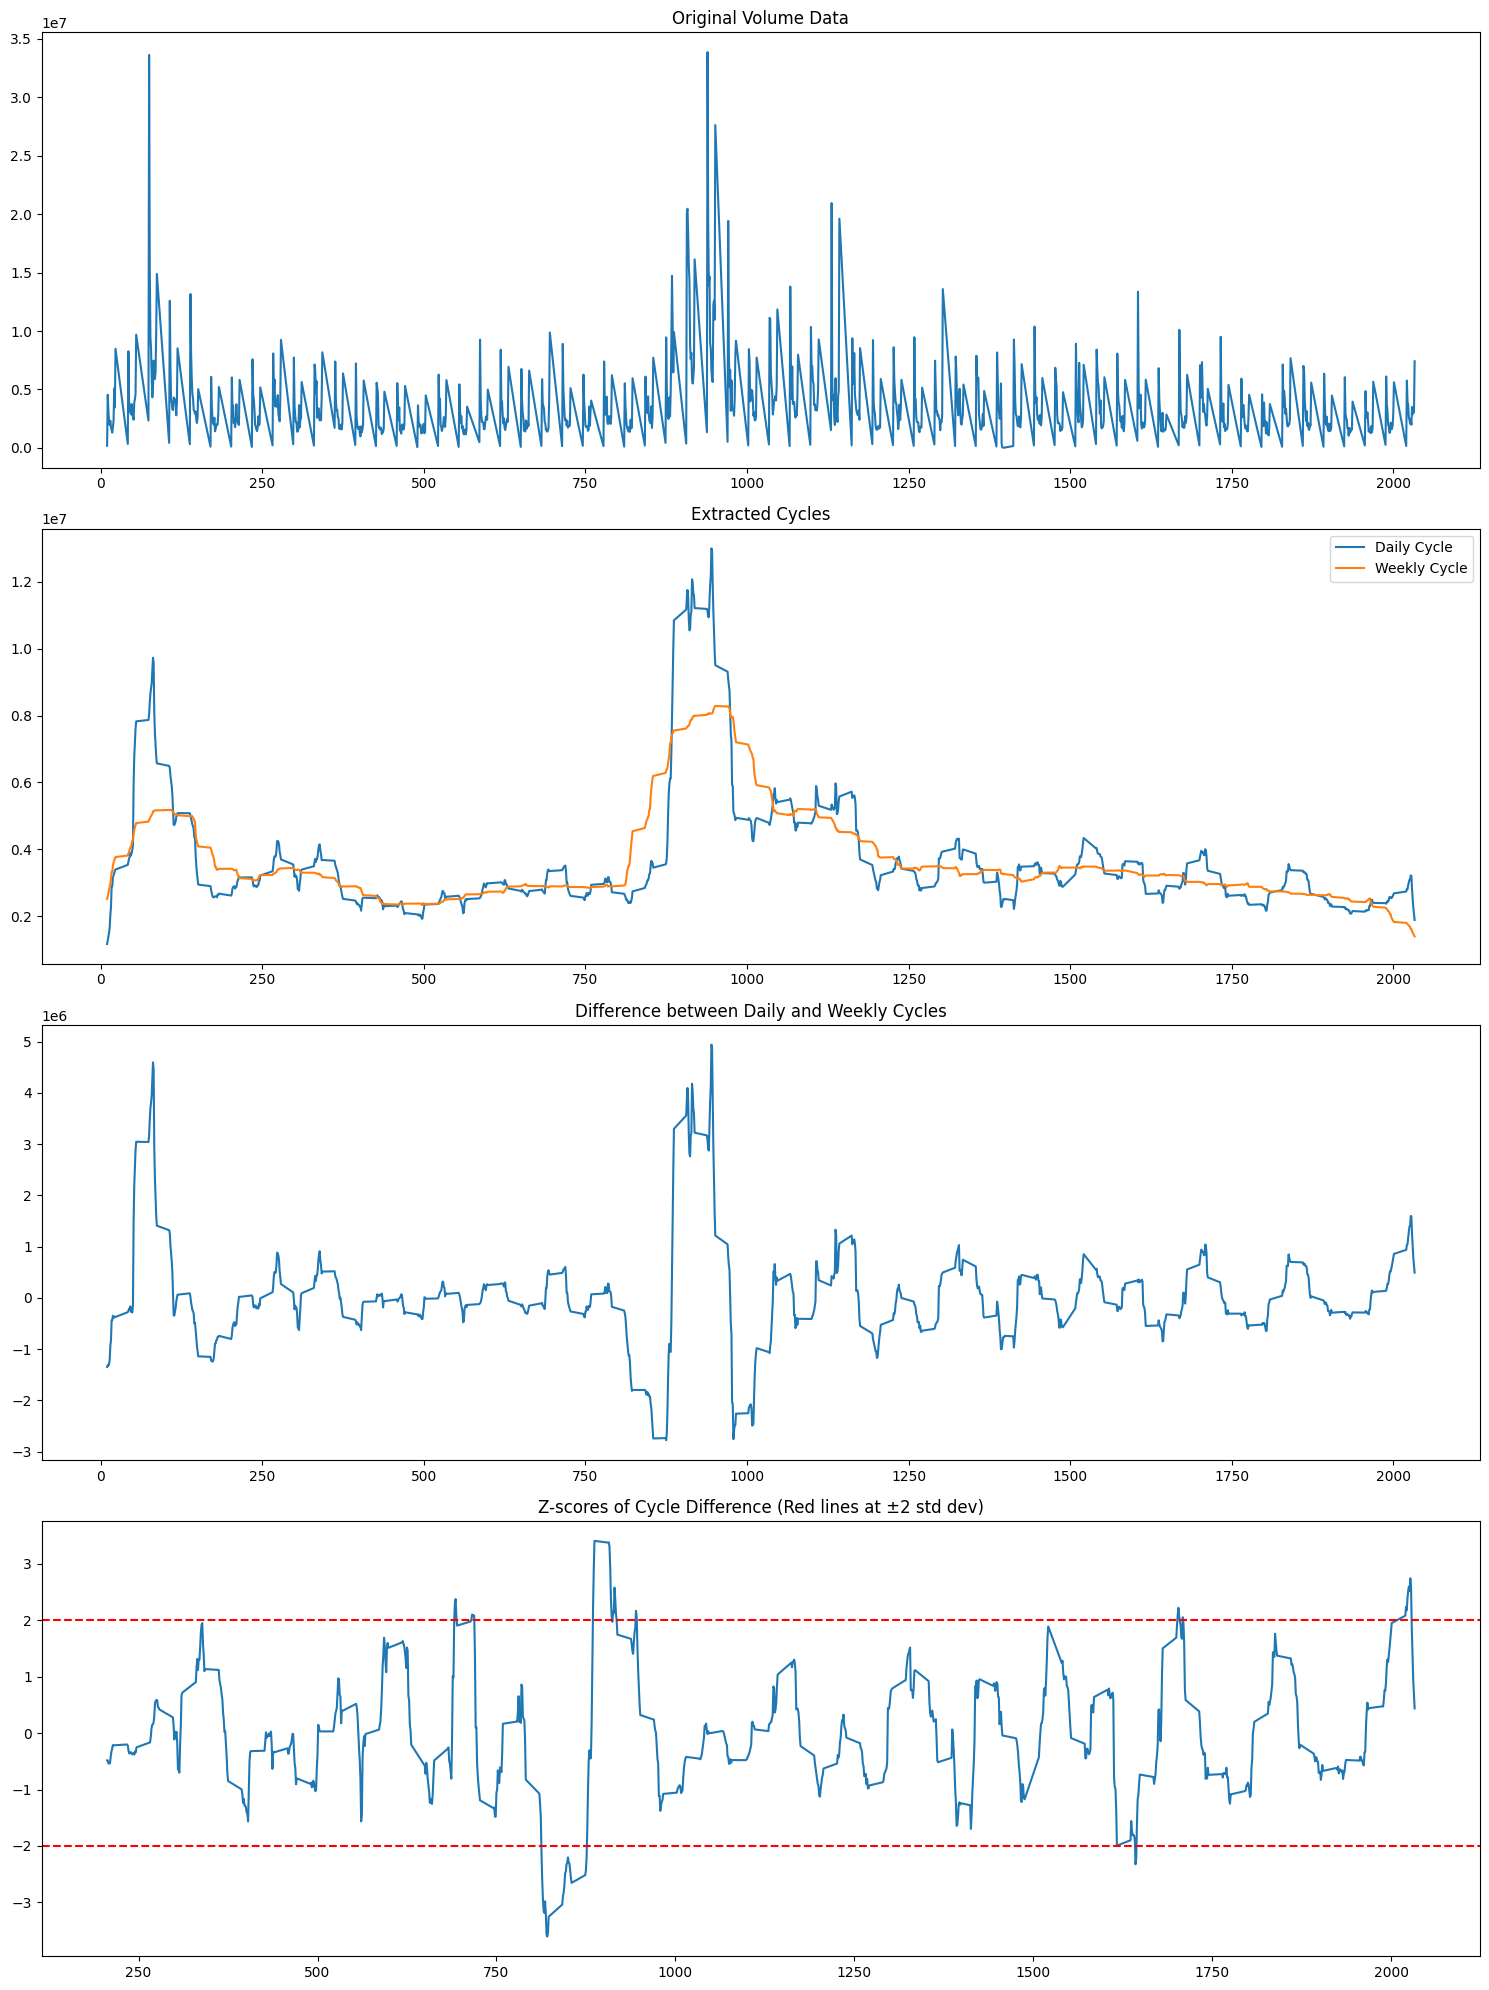

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [4]:
import numpy as np
import pandas as pd
import pywt
import matplotlib.pyplot as plt
from scipy import signal

data = call_polygon("AAPL", "2024-05-01", "2024-08-01", "minute", 30)
volume_data = data['v']

def wavelet_analysis(data, wavelet='db8', max_level=None):
    if max_level is None:
        max_level = pywt.dwt_max_level(len(data), pywt.Wavelet(wavelet).dec_len)
    
    coeffs = pywt.wavedec(data, wavelet, level=max_level)
    reconstructed = []
    for i in range(max_level + 1):
        coeff_list = [np.zeros_like(c) for c in coeffs]
        coeff_list[i] = coeffs[i]
        reconstructed.append(pywt.waverec(coeff_list, wavelet))
    return reconstructed, coeffs

def extract_cycle(data, cycle_length):
    # Use convolution to extract the cycle
    kernel = np.ones(cycle_length) / cycle_length
    extracted_cycle = np.convolve(data, kernel, mode='same')
    return extracted_cycle

def compare_cycles(short_cycle, long_cycle):
    # Compute the difference between the short and long cycles
    difference = short_cycle - long_cycle
    
    # Compute rolling statistics
    window = len(short_cycle) // 10  # Use 10% of the data as the window
    rolling_mean = pd.Series(difference).rolling(window=window).mean()
    rolling_std = pd.Series(difference).rolling(window=window).std()
    
    # Compute z-scores to identify significant divergences
    z_scores = (difference - rolling_mean) / rolling_std
    
    return difference, z_scores

# Perform wavelet analysis
reconstructed, coeffs = wavelet_analysis(volume_data.values)

# Extract daily and weekly cycles
daily_cycle_length = 14  # 48 30-minute intervals in a day
weekly_cycle_length = 14 * 5  # 7 days * 48 intervals per day

daily_cycle = extract_cycle(volume_data.values, daily_cycle_length)
weekly_cycle = extract_cycle(volume_data.values, weekly_cycle_length)

# Compare daily cycle to weekly cycle
cycle_difference, cycle_z_scores = compare_cycles(daily_cycle, weekly_cycle)

# Plot results
fig, axs = plt.subplots(4, 1, figsize=(15, 20))

axs[0].plot(volume_data.index, volume_data.values)
axs[0].set_title('Original Volume Data')

axs[1].plot(volume_data.index, daily_cycle, label='Daily Cycle')
axs[1].plot(volume_data.index, weekly_cycle, label='Weekly Cycle')
axs[1].set_title('Extracted Cycles')
axs[1].legend()

axs[2].plot(volume_data.index, cycle_difference)
axs[2].set_title('Difference between Daily and Weekly Cycles')

axs[3].plot(volume_data.index, cycle_z_scores)
axs[3].axhline(y=2, color='r', linestyle='--')
axs[3].axhline(y=-2, color='r', linestyle='--')
axs[3].set_title('Z-scores of Cycle Difference (Red lines at ±2 std dev)')

plt.tight_layout()
plt.show()

# Identify significant divergences
significant_divergences = volume_data[np.abs(cycle_z_scores) > 2]
print(f"Number of significant divergences: {len(significant_divergences)}")
if len(significant_divergences) > 0:
    print("\nTop 5 most significant divergences:")
    print(significant_divergences.sort_values(key=lambda x: np.abs(cycle_z_scores[x.index]), ascending=False).head())

# Compute and print cycle strength
daily_cycle_strength = np.std(daily_cycle) / np.std(volume_data.values)
weekly_cycle_strength = np.std(weekly_cycle) / np.std(volume_data.values)
print(f"\nDaily cycle strength: {daily_cycle_strength:.4f}")
print(f"Weekly cycle strength: {weekly_cycle_strength:.4f}")

# Compute and print average divergence
avg_divergence = np.mean(np.abs(cycle_difference))
print(f"\nAverage absolute divergence between daily and weekly cycles: {avg_divergence:.4f}")

# Compute and print correlation between cycles
correlation = np.corrcoef(daily_cycle, weekly_cycle)[0, 1]
print(f"Correlation between daily and weekly cycles: {correlation:.4f}")